Most up to date version (2/3/21)

Some changes done 3/2/21 to redo 10-AR sims

Latest changes done 3/18/21 to allow for picking AR's from a certain hemisphere

Little tweak while making both_hems dataset 4/14/21, to pick from both hemispheres equally

And now 6/2/21, working on a south-only test dataset real quick




7/3/21 welp. let's just call these datasets 'hail mary'
(redoing literally fucking everything to try and avoid the nan's plagueing the fixed_aia redos. hamburger help me)

Hey there it's 10/1 and I survived/ defended this shit successfully, time to do it for all the data real quick before I get the fuck out of dodge

so, I need two more models? one more model? probably two to be safe, just retrain the north one? I'm ahead of myself. Two models, one north only, one south only. There should already be a good dataset around for the north one (I just have to figure out which one that is oh boy) so we should be here today to just make (+transfer+train with) a south only dataset. No test lists needed really, it'll all be on the "test list" in the end.

In [1]:
import csv
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import sys
import random
import datetime
import traceback
from tqdm import tqdm

#wow this is a Lot huh. and only growing

I should really make this more modular since I'm gonna be using it many, many times... but since I always end up having to go in and clean up the file lists by hand a little bit anyway, 

Makes list of all files- just fits for now


aia_files = '/home/zenalisa/data/aia/*/*.fits'
hmi_files = '/home/zenalisa/data/hmi/*/*.fits'
table = open('/home/zenalisa/data/AR_list_new.csv', 'w')


aia_file_list = glob.glob(aia_files)
hmi_file_list = glob.glob(hmi_files)

#print len(hmi_file_list)
#print len(aia_file_list) #these don't match- I feel like that might not be a good sign

w = csv.writer(table, delimiter = ',')

for n in range(len(aia_file_list)):
    
    try:
        w.writerow([aia_file_list[n], hmi_file_list[n]])
    except IndexError:
        w.writerow([aia_file_list[n], ''])
        
        break
        
table.close()
#print 'Done'

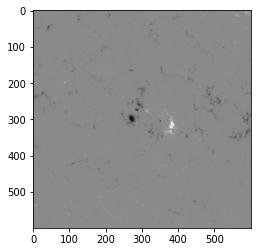

In [29]:
test=glob.glob('/home/zenalisa/data/1hem_south/hmi/*/*')[1700]
t=Image.open(test)
t=np.array(t)
plt.imshow(t, cmap='gray')



In [2]:
#edited 10/13/20 to get a uniform zero level for signed magnetograms
#1/28/21 futzing with conversion specifics- added round before cast to uint8, fixed "uint8 and then also log" for aia, 
#does both the old log10 version of aia and the basic ol' -min, /max*255 
#does hmi abs correctly now, I think? double check
#Do I want to do something more similar to the hmi (with a set offset value) with aia? think about that later
# ^guess what asshole, it's later (6/28 adding clipping for AIA)

#old version that doesn't do that ^ moved below and renamed

def fits_to_tiff(filepath, img_type, r=False, outp_name=None, absval=False, log_10=True):
    '''Does the conversion from .fits data to .tiff images, saves .tiff files under new name and directory. 
    Inputs: filepath (string, full path to the file ie '/home/zenalisa/data/dataset_name/AR_number/filename.fits' )
            img_type (string, either 'aia' or 'hmi'. Have to specify because they need slightly different preprocessing steps before converting to a uint8 image)
            r (bool flag that controls whether or not to rotate the data- leftover from when I randomly rotated the training data by either 0 or 180 degrees to artificially remove any hemisphere bias, should be able to leave as False. If you did want to rotate, you'd want to randomly set r=True half the time you call this function, and be sure to have the same random flag for both the AIA and corresponding HMI image.)
            outp_name (string, new output directory for .tiff files. If left as default, will add /tiff just before the AR number in filepath argument to make a new directory and save there. ie if the original fits location is '/home/zenalisa/data/dataset_name/AR_number/file_name.fits', default output location is '/home/zenalisa/data/dataset_name/tiff', and new file will save as '/home/zenalisa/data/dataset_name/tiff/AR_number/file_name.tiff'. I didn't use the default often, preferred to specify my own new output spot.)
            absval (bool flag controls whether or not to take absolute value of HMI data. Less relevant now that we're doing this for signed magnetograms, but, I'll leave it in case anybody ever wants to use it.)
            log_10 (bool flag that controls whether or not to take log10 of AIA data. Can probably be left as True, but again I'll leave the option just in case.)
    Outputs: string name of new .tiff file, min data value, max data value.
    Notes: Current version doesn't do any clipping to AIA data before converting to uint8, just scales each image according to its own min and max values. I wrote more on why that's not the best way to do this and why I did it anyway in the thesis, but it's something to be aware of (and fix, in my opinion) if you're improving on this process in the future. I added some notes in the readme too on some weird technical difficulties that popped up when I did try the AIA clipping, highly recommend taking a peek at that if you're tackling the clipping problem, might spare you from the multiple days of NaN hunting that I suffered through.'''

    name, ext = os.path.splitext(filepath)
    
    if not outp_name:
        outp_name = name.replace(name.split('/')[-2], name.split('/')[-2]+'/tiff') #places new files in separate directory
    
    img = fits.open(filepath)
    img.verify('fix')

    #img.info()

    data = img[1].data #has to be img[1]
    
    if r:
        data=np.rot90(data)
        data=np.rot90(data)
    
    width = data.shape[1]
    height = data.shape[0]
    
    #aia_max=2550 
    #aia_min=1 #helps with log yelling at me
    hmi_offset=2550
    
    if img_type == 'aia':
        
        if log_10:
            data = np.log10(data - np.amin(data))
        else:
            data=data-np.amin(data)
        
        data=data.astype(float)/np.amax(data)*255
        data=np.round(data)
        data=data.astype(np.uint8)
        #print(data)
        #this nan detecting block (and the identical one below) were from the aia clipping fiasco, turns out the problem wasn't because of nan's in the data itself anyway, @me TODO write all those details out later in case some other poor asshole runs into the same problem later
        #if np.isnan(np.sum(data)) or np.isinf(np.sum(data)):
        #    print('uh oh spaghetti-o\'s')
        #    raise KeyError
            
        
    elif img_type == 'hmi':
        if absval:
            data = abs(data)
        
        data[data>hmi_offset]=hmi_offset
        data[data<-hmi_offset]=-hmi_offset
        data=data+hmi_offset
        data=data*255./(2*hmi_offset)
        data=np.round(data)
        data=data.astype(np.uint8)
        
    outputArray = np.array(data, dtype=np.uint8)

    output = Image.fromarray(outputArray.reshape((height, width)), "L")

    if not os.path.exists(outp_name + '/' +  name.split('/')[-2]):
        os.makedirs(outp_name + '/' +  name.split('/')[-2])
    
    output.save(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff")
    img.close()
    
    return(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff", data.min(), data.max())


def fits_to_tiff_old(filepath, img_type, outp_name=None, absval=False, log_10=False):
   '''An older version of above, I don't actually remember what the big differences are, but. leaving it here just in case'''
    name, ext = os.path.splitext(filepath)
    
    if not outp_name:
        outp_name = name.replace(name.split('/')[-2], name.split('/')[-2]+'/tiff') #places new files in separate directory
    
    img = fits.open(filepath)
    img.verify('fix')

    #img.info()

    data = img[1].data #has to be img[1]
    
    #for south_only test dataset. Please for the love of god don't forget to remove later
    #data=np.rot90(data)
    #data=np.rot90(data)
    
    
    
    width = data.shape[1]
    height = data.shape[0]
    
    #aia_offset=tbd
    hmi_offset=2550
    
    if img_type == 'aia':
        
        if log_10:
            data = np.log10(data - np.amin(data))
        else:
            data=data-np.amin(data)
        
        data=data.astype(float)/np.amax(data)*255
        data=np.round(data)
        data=data.astype(np.uint8)
            
        #else: #clip by standard offset like with hmi. may do later but since we don't need a uniform zero level here, skipping for now
        #    data[data>aia_offset]=aia_offset
        #    data[data<-aia_offset]=-aia_offset
        #    data=data+aia_offset
        #    data=data*255./(2*aia_offset)
        #    data=np.round(data)
        #    data=data.astype(np.uint8)
        
    elif img_type == 'hmi':
        if absval:
            data = abs(data)
        
        data[data>hmi_offset]=hmi_offset
        data[data<-hmi_offset]=-hmi_offset
        data=data+hmi_offset
        data=data*255./(2*hmi_offset)
        data=np.round(data)
        data=data.astype(np.uint8)
        
        #else:
            #data = data - data.min()
            
    #data = data.astype(float)/data.max() * 225 #normalize data and multiply by 225 to map to uint8 values
    
    outputArray = np.array(data, dtype=np.uint8)

    output = Image.fromarray(outputArray.reshape((height, width)), "L")

    if not os.path.exists(outp_name + '/' +  name.split('/')[-2]):
        os.makedirs(outp_name + '/' +  name.split('/')[-2])
    
    output.save(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff")
    img.close()
    
    return(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff", data.min(), data.max())

In [3]:
#for sorting file lists by time
def timestamp(filename):
    t = filename.split('/')[-1].split('.')[2]
    return t

In [4]:
def timediff(file1, file2):
    '''calculates difference in timestamps between two files. Used to make sure HMI and AIA files are close enough in time to be an image pair.
    Inputs: file1 and file2, paths to the fiels you want to compare. Doesn't matter which order you pass these in (file1=hmi, file2=aia or vice versa), try/except part of this function covers it both ways
    Outputs: the absolute difference in seconds between the two files' timestamps.'''
    try:
        file1_time = file1.split('/')[-1].split('.')[2].split('Z')[0]
        file1_time = datetime.datetime.strptime(file1_time, '%Y-%m-%dT%H%M%S')
    except ValueError:
        file1_time = file1.split('/')[-1].split('.')[2].split('TAI')[0]
        file1_time = datetime.datetime.strptime(file1_time, '%Y%m%d_%H%M%S_')
        
    try:
        file2_time = file2.split('/')[-1].split('.')[2].split('Z')[0]
        file2_time = datetime.datetime.strptime(file2_time, '%Y-%m-%dT%H%M%S')
    except ValueError:
        file2_time = file2.split('/')[-1].split('.')[2].split('TAI')[0]
        file2_time = datetime.datetime.strptime(file2_time, '%Y%m%d_%H%M%S_')
    

    return abs(file1_time - file2_time)
    

#fits goofin, looking for that sweet sweet metadata 
for r in range(1076, 2693):

    try:
        testfile=glob.glob('/mnt/zena/active_regions/'+str(r)+'/*.fits')[0]
        #print(testfile)

        img= fits.open(testfile)
        img.verify('fix')
        print(img[1].header)
        d=img[1].data
        #print(np.amin(d), np.amax(d))
        break
    except IndexError:
        continue


I THINK these are all the keywords from above header that have to do with coordinates. Rip me I have no idea what's going on here

CTYPE1  = 'HPLN-TAN'                                                            
CTYPE2  = 'HPLT-TAN'                                                            
CRPIX1  = -761.797974                                                           
CRPIX2  = 937.674316                                                            
CRVAL1  = 0.000000                                                              
CRVAL2  = 0.000000                                                              
CDELT1  = 0.504354                                                              
CDELT2  = 0.504354                                                              
CUNIT1  = 'arcsec'                                                              
CUNIT2  = 'arcsec'                                                              
CROTA2  = 0.0136                                                                
CRDER1  = 'nan     '                                                            
CRDER2  = 'nan     '                                                            
CSYSER1 = 'nan     '                                                            
CSYSER2 = 'nan     '                                                            
WCSNAME = 'Helioprojective-cartesian'                                           

In [5]:
#function-ized 4/14/21 to clean up next block
def which_hem(fname):
    srs='/home/zenalisa/data/SRS/'
    simple_date=fname.split('.')[-4].split('_')[0]
    #print(simple_date)
    date=datetime.datetime.strptime(simple_date, '%Y%m%d')
    #print(date.year)
    srs_file=srs+str(date.year)+'_SRS/'+str(simple_date)+'SRS.txt'
    #print(srs_file)
    srs_file=open(srs_file, 'r')
    lines=srs_file.readlines()
    for l in lines:
        if 'I.  Regions with Sunspots.' in l:
            start=lines.index(l)
        if 'IA. H-alpha Plages without Spots.' in l:
            stop=lines.index(l)
            break
    region_locs=lines[start+2:stop]
    for l in region_locs:
        if l.split(' ')[0]==str(r):
            h=l.split(' ')[1][0]
            break
    return h
            

### where the real stuff starts

In [9]:
last_50= [2103, 2266, 2422, 2455, 2564, 1716, 1483, 1551, 1897, 1305, 1349, 1809, 2265, 2061, 2691, 1403, 2397, 2441, 2398, 2214, 1958, 1773, 1431, 2586, 1312, 2645, 2423, 1542, 1157, 2310, 2557, 1551, 1453, 1911, 2496, 2440, 2218, 1459, 1281, 1828, 2590, 1492, 2476, 2466, 1795, 2293, 1857, 2358, 1784, 2167]
extras = [1698, 1792, 2363, 1805, 1522, 1634, 2025, 1747, 1686, 1604]
last50_full=last_50+extras
print(len(set(last50_full)))

59


oops ^

In [35]:
#save these before I overwrite them here in a sec
aia_list_last50=aia_file_list
hmi_list_last50=hmi_file_list

In [56]:
diff_50 = [1518, 2228, 1919, 2643, 2084, 1674, 2448, 2402, 2457, 2089, 1528, 2365, 1541, 2501, 1242, 2369, 2170, 2232, 1964, 1512, 2606, 1320, 1273, 1505, 2567, 1277, 2539, 1548, 2491, 1380, 1979, 1663, 2185, 1464, 1966, 1847, 1751, 1392, 1729, 1757, 2301, 1718, 2684, 1991, 2149, 1324, 2639, 1232, 1537, 1960, 2411, 2157, 1816, 2035, 1410]

In [125]:
onehem_train = [1811, 2644, 2504, 1265, 1365, 2689, 2531, 2317, 2606, 2619, 1360, 2610, 1624, 1425, 1357, 2167, 2514, 1117, 2632, 1487, 1648, 1225, 1410, 1537, 1923, 1887, 1651, 2550, 1293, 2027, 1271, 1516, 1957, 1296, 2499, 2482, 2009, 2651, 1635, 1242, 1764, 1979, 2575, 2089, 1867, 2579, 1753, 2050, 2263, 2240, 2525, 2001, 1500]

In [16]:
#make (and sort and clean up) master lists of files


aia_files = '/mnt/zena/AIA/'
hmi_files = '/mnt/zena/active_regions/'
srs='/home/zenalisa/data/SRS/' #added 3/18/21, location of SRS metadata files

hems=1 #for signed HMI data, set to either 1 (pick from one hemisphere) or 2 (pick equal amount of data from both)
hem_list=[]
aia_file_list = []
hmi_file_list = []
min_images=115#want at least this many images per AR. changes based on how many AR's and whether it's train and test or just test so @me pls pay attention here

#this is for the latest 52AR dataset, I think?
#actual_arlist=[1156, 1242, 1249, 1263, 1273, 1283, 1299, 1370, 1377, 1396, 1426, 1461, 1481, 1546, 1603, 1622, 1625, 1629, 1635, 1640, 1654, 1685, 1694, 1755, 1756, 1792, 1854, 1877, 1917, 1946, 1958, 2034, 2061, 2092, 2162, 2215, 2293, 2319, 2334, 2359, 2373, 2437, 2450, 2452, 2467, 2483, 2488, 2521, 2538, 2539, 2557, 2692]

#regions=[2227, 1503, 1849, 2369, 1106, 2394, 1938, 2101, 2390, 2541] #already used in 190604
#used in first 50-AR list: [2206, 1291, 2650, 1245, 2054, 1993, 2414, 2006, 1100, 2538, 1757, 2278, 1953, 1371, 1806, 2315, 2334, 1292, 1279, 2429, 2571, 2305, 2009, 1761, 1943, 2204, 2441, 1543, 2655, 1834, 2316, 1465, 2069, 1756, 2637, 1660, 2465, 1243, 1972, 2072, 1595, 1737, 2503, 2654, 2552, 2226, 2217, 2597, 2179, 1112]
newregions = []
#last_50 = [2103, 2266, 2422, 2455, 2564, 1716, 1483, 1551, 1897, 1305, 1349, 1809, 2265, 2061, 2691, 1403, 2397, 2441, 2398, 2214, 1958, 1773, 1431, 2586, 1312, 2645, 2423, 1542, 1157, 2310, 2557, 1551, 1453, 1911, 2496, 2440, 2218, 1459, 1281, 1828, 2590, 1492, 2476, 2466, 1795, 2293, 1857, 2358, 1784, 2167]
#last (newARs):[1298, 2187, 2436]

#onehem_trainlist=[2504, 1667, 2439, 1836, 2563, 2548, 2005, 2223, 2421, 2033, 2139, 2475, 1425, 1589, 1342, 2485, 1996, 2541, 1695, 1678, 1580, 2325, 1945, 1691, 1692, 1479, 1880, 2100, 1902, 1225, 1092, 1979, 2666, 1779, 2402, 2448, 1305, 1302, 1482, 1208, 2369, 2532, 1260, 1986, 1631, 1921, 2554, 2456, 2606, 1600]

n = 52
while len(newregions) < n:
    #if len(newregions)%100==0: #for hugelarge lists
        #print len(newregions)
    r = random.randint(1076, 2693)
    if os.path.exists(hmi_files+str(r)) and os.path.exists(aia_files+str(r)) and r not in newregions:# and r not in onehem_train: #last bit added 2/4/21 to get one or two more AR's on top of the ones in actual_arlist (see below), remove if you do this again from scratch
        
        
        #print 'HERE' #if this takes >10s to run and it's not the first time you've tried to run it since starting the notebook, try this- drive may not be mounted
        newregions.append(r)
        
        aia_temp = glob.glob(aia_files+str(r)+'/*.fits')
        aia_temp.sort(key = timestamp)
        hmi_temp = glob.glob(hmi_files+str(r)+'/*.fits')
        hmi_temp.sort(key = timestamp)
        
        if aia_temp == [] or hmi_temp == []:#there seems to be some empty directories... remind me to look into that later
            newregions.remove(r)
            continue
        

        #which list is shorter
        if len(hmi_temp) <= len(aia_temp):
            shortlist = hmi_temp
            longlist = aia_temp
        else:
            shortlist = aia_temp
            longlist = hmi_temp
        
        #if there are too few images, remove/skip this AR
        if len(shortlist)<min_images:
            newregions.remove(r)
            continue
            
        #print len(longlist), len(shortlist)
        try:
            for i in range(len(shortlist)):
                dt = timediff(shortlist[i], longlist[i])
                j = 0
                while dt > datetime.timedelta(seconds=720):
                    k = i + j
                    del longlist[k]
                    j += 1
                    dt = timediff(shortlist[i], longlist[k+1])
                    #print dt
        
        
        except IndexError:
            pass
            
        
            
        #print len(longlist), len(shortlist)
        #break
        #print(shortlist[0])
        
        #--------------------------------------------
        if hems==1: #3/18/21, for if we need to go get SRS files to find out what hemisphere the AR is in
            hemisphere=which_hem(hmi_temp[0])
            #print(hemisphere)      
            if hemisphere != 'S':#sure idk, n vs s shouldn't matter as long as they're all the same, yeah?
                newregions.remove(r)
                continue #move on to a different AR if it's not in the hemisphere we want
            hem_list.append(hemisphere)
        #if hems==2: #4/14/21 but I don't think I ever actually used this, oops
        #    last_hem=hemisphere
        #    hemisphere=which_hem(hmi_temp[0])
        #    #print(hemisphere)      
        #    if hemisphere == last_hem:#should give us alternating hemispheres for the AR's
        #        newregions.remove(r)
        #        continue #move on to a different AR if it's not in the hemisphere we want
        #    hem_list.append(hemisphere)
            #raise KeyError
        #--------------------------------------------
        
        
        for i in range(len(shortlist)):
            
            #print timediff(shortlist[i], longlist[i])
            try:
                if timediff(shortlist[i], longlist[i]) > datetime.timedelta(seconds=720):
                    del shortlist[i]
                    del longlist[i]
                    continue
                #print timediff(shortlist[i], longlist[i])
        
            except IndexError:
                shortlist = shortlist[:i-1]
                longlist = longlist[:i-1]
                break
        
        #added for debugging 2/3/21
        #for i in range(len(shortlist)):
        #    print(timediff(shortlist[i], longlist[i]))
        
      
        try:#added 3/18/21
            randimg=random.sample(range(len(shortlist)), min_images)
        except ValueError: #if we've for a sample larger than the population
            continue #just skip it and try again
        randimg.sort()
        shortlist=[shortlist[r] for r in randimg]
        longlist=[longlist[r] for r in randimg]
        
        if len(longlist) == len(shortlist) and len(longlist)!=0:
            if 'AIA' in longlist[0]:
                    aia_file_list += longlist
                    hmi_file_list += shortlist
            else:
                    aia_file_list += shortlist
                    hmi_file_list += longlist



print(len(hmi_file_list), len(aia_file_list))
print(newregions)  
print(hem_list.count('N'), hem_list.count('S'))
#last (190604): [2227, 1503, 1849, 2369, 1106, 2394, 1938, 2101, 2390, 2541]

5980 5980
[1814, 1709, 1750, 2182, 1861, 1655, 1860, 2327, 2609, 1823, 1906, 2088, 1785, 1972, 2350, 2237, 2226, 2320, 1806, 2198, 2560, 2199, 2108, 2316, 1928, 1454, 1682, 1382, 2153, 1378, 1733, 2401, 2416, 2222, 2197, 1716, 2645, 2332, 1775, 1936, 1857, 2691, 2658, 1449, 1483, 1529, 1657, 1470, 1414, 2207, 1800, 1780]
0 52


10/1/21 south only training AR's: [1814, 1709, 1750, 2182, 1861, 1655, 1860, 2327, 2609, 1823, 1906, 2088, 1785, 1972, 2350, 2237, 2226, 2320, 1806, 2198, 2560, 2199, 2108, 2316, 1928, 1454, 1682, 1382, 2153, 1378, 1733, 2401, 2416, 2222, 2197, 1716, 2645, 2332, 1775, 1936, 1857, 2691, 2658, 1449, 1483, 1529, 1657, 1470, 1414, 2207, 1800, 1780]

Training ar's for both_hems: [2168, 2521, 2087, 1843, 1706, 2629, 2119, 2064, 1770, 2287, 1955, 2086, 1889, 1423, 2297, 1365, 1598, 1417, 1106, 1474, 2337, 1460, 1471, 1157, 1436, 2031, 1689, 1674, 1489, 2647, 1165, 2686, 1705, 2657, 1158, 1743, 1459, 2512, 2364, 2650, 2179, 2195, 1599, 1668, 1750, 1377, 1344, 2022, 1938, 2426, 2131, 2626]

Test C (southern hemisphere only) AR's: [2002, 2675, 1622, 2405, 1967, 2397, 2143, 2185, 2410, 2126, 2213, 1642, 1649, 1299, 2660, 1485, 1571, 1972, 1949, 2206, 1841, 1627, 1389, 1106, 2545, 2471, 1749, 2256, 1524, 1379, 2341, 1930, 1984, 2229, 1585, 2468, 1316, 1267, 1971, 1639, 1994, 2358, 1089, 1775, 2178, 1463, 1386, 2099, 1453, 1877]

7/3/21
the last fucking time I'm doing this, train AR's for regular degular 50AR dataset = [2103, 2266, 2422, 2455, 2564, 1716, 1483, 1551, 1897, 1305, 1349, 1809, 2265, 2061, 2691, 1403, 2397, 2441, 2398, 2214, 1958, 1773, 1431, 2586, 1312, 2645, 2423, 1542, 1157, 2310, 2557, 1551, 1453, 1911, 2496, 2440, 2218, 1459, 1281, 1828, 2590, 1492, 2476, 2466, 1795, 2293, 1857, 2358, 1784, 2167]

extras because we ended up with too few = [1698, 1792, 2363, 1805, 1522, 1634, 2025, 1747, 1686, 1604]

DiffAR's for above = [1518, 2228, 1919, 2643, 2084, 1674, 2448, 2402, 2457, 2089, 1528, 2365, 1541, 2501, 1242, 2369, 2170, 2232, 1964, 1512, 2606, 1320, 1273, 1505, 2567, 1277, 2539, 1548, 2491, 1380, 1979, 1663, 2185, 1464, 1966, 1847, 1751, 1392, 1729, 1757, 2301, 1718, 2684, 1991, 2149, 1324, 2639, 1232, 1537, 1960, 2411, 2157, 1816, 2035, 1410]

7/3/21
10ar train = [1336, 1443, 2654, 1605, 1399, 2143, 1471, 1423, 2267, 1372, 2261, 2638]

7/3/21
(techncially it's the 4th now tho)
1hem trainAR's = [1811, 2644, 2504, 1265, 1365, 2689, 2531, 2317, 2606, 2619, 1360, 2610, 1624, 1425, 1357, 2167, 2514, 1117, 2632, 1487, 1648, 1225, 1410, 1537, 1923, 1887, 1651, 2550, 1293, 2027, 1271, 1516, 1957, 1296, 2499, 2482, 2009, 2651, 1635, 1242, 1764, 1979, 2575, 2089, 1867, 2579, 1753, 2050, 2263, 2240, 2525, 2001, 1500]

1hem diffAR's: [2030, 1809, 1301, 1826, 1443, 2511, 2558, 1246, 2638, 2361, 2453, 1902, 1341, 1825, 1618, 2120, 2540, 1183, 2524, 2641, 1384, 2663, 2627, 1248, 2086, 2462, 2176, 2419, 1748, 1946, 2529, 2342, 1231, 1130, 1625, 2264, 2180, 2385, 1954, 1362, 2469, 2489, 1432, 2212, 2343, 1326, 1309, 1684, 1560, 1468, 1675, 2239, 1371]

southAR's: [1508, 2151, 1267, 2294, 1914, 1909, 2041, 2384, 1805, 2051, 1176, 1428, 1505, 2253, 2186, 2147, 1123, 2209, 2331, 2584, 1386, 2665, 1472, 1585, 1981, 1490, 2259, 2423, 2127, 1381, 1538, 2422, 1901, 2547, 2289, 2435, 2225, 1374, 1418, 2025, 1078, 1497, 2196, 2334, 2399, 1959, 1367, 1723, 1609, 1234, 2200, 1859]

In [ ]:
#not current as of 7/3/21 but I aint deleting it
newhemar=[2134, 1641, 1291, 1702, 1383, 2513, 1738, 2024, 1362, 2115, 1309, 1668, 1621, 2055, 2324, 1366, 1113, 2156, 1288, 1792, 2534, 1713, 2042, 1516, 2362, 1764, 1293, 2133, 1364, 1656, 2491, 2386, 2603, 2022, 2269, 2111, 2503, 2409, 1808, 2007, 1742, 2287, 2664, 2626, 2531, 2183, 2284, 2246, 1640, 2625]
trainedhemar=[2504, 1667, 2439, 1836, 2563, 2548, 2005, 2223, 2421, 2033, 2139, 2475, 1425, 1589, 1342, 2485, 1996, 2541, 1695, 1678, 1580, 2325, 1945, 1691, 1692, 1479, 1880, 2100, 1902, 1225, 1092, 1979, 2666, 1779, 2402, 2448, 1305, 1302, 1482, 1208, 2369, 2532, 1260, 1986, 1631, 1921, 2554, 2456, 2606, 1600]
print([f for f in newhemar if f in trainedhemar])


New AR's (not seen in training) for dataset 210128: [1166, 2349, 1918, 1258, 2039, 2217, 2011, 1565, 1500, 2283, 2143, 1473, 2537, 2534, 2443, 1944, 1440, 2339, 1724, 2597, 1564, 1930, 2485, 2086, 2398, 1421, 2487, 2305, 1750, 1499, 2288, 2265, 1557, 1078, 2674, 1637, 1617, 1560, 1840, 2651, 1893, 2122, 2112, 1445, 1476, 1956, 2016, 1897, 1353, 1429]

for a in aia_file_list:
    print a

for i in range(len(shortlist)):
    #print timediff(shortlist[i], longlist[i])
    try:
        if timediff(shortlist[i], longlist[i]) > datetime.timedelta(seconds=720):
            del shortlist[i]
            del longlist[i]
            continue
        #print timediff(shortlist[i], longlist[i])
        
    except IndexError:
        shortlist = shortlist[:i-1]
        longlist = longlist[:i-1]
        break
        
print len(longlist), len(shortlist)

In [5]:
#some testing for which AR's got used for the 10ar and which for the 50_new
ten=[1120, 1849, 1259, 1484, 1662, 2244, 1738, 2365, 2193, 1301]
fifty=[1078,  1421,  1473,  1557,  1617,  1840,  1930,  2016,  2122,  2283,  2349,  2487,  2651, 1166,  1429,  1476,  1560, 1637,  1893,  1944,  2039,  2143,  2288,  2398,  2534,  2674, 1258,  1440,  1499,  1564,  1724,  1897, 1956,  2086,  2217,  2305,  2443,  2537, 1353,  1445,  1500,  1565,  1750,  1918,  2011,  2112,  2265,  2339,  2485,  2597]

print([f for f in ten if f in fifty])
#sometimes luck is indeed on my side :D

[]


#check if aia and hmi files actually match up 1 to 1 by comparing timestamps
import datetime

for i in range(len(aia_file_list)):
    aia_file = aia_file_list[i]
    hmi_file = hmi_file_list[i]
    
    aia_time = aia_file.split('/')[-1].split('.')[2].split('Z')[0]
    hmi_time = hmi_file.split('/')[-1].split('.')[2].split('TAI')[0]
    
    aia_time = datetime.datetime.strptime(aia_time, '%Y-%m-%dT%H%M%S')
    hmi_time = datetime.datetime.strptime(hmi_time, '%Y%m%d_%H%M%S_')
    print hmi_time - aia_time
    #break
    

#I don't remember what this one was, just a test hopefully
image_file = "/mnt/zena/AIA/1567/aia.lev1_euv_12s.2012-09-07T235925Z.304.image.fits"

hdu_list = fits.open(image_file)
hdu_list.verify('fix') 
#hdu_list.info()

image_data = hdu_list[1].data

hdu_list.close()

plt.imshow(abs(image_data),cmap='gray')

In [17]:
#check fits files for nan's
#the one that takes a long ass fuckin time

aia_file_list_new = []
hmi_file_list_new = []
for n in tqdm(range(len(aia_file_list))):
    #if n%100 == 0:
    #    print n
    a_fits = fits.open(aia_file_list[n])
    a_fits.verify('fix')
    a = a_fits[1].data
    h_fits = fits.open(hmi_file_list[n])
    h_fits.verify('fix')
    h = h_fits[1].data
    
    a_fits.close()
    h_fits.close()
    
    if np.isnan(a).any() or np.isnan(h).any():
        pass
    else:
        aia_file_list_new.append(aia_file_list[n])
        hmi_file_list_new.append(hmi_file_list[n])
        
    
#added for debugging 2/3/21. Can leave in if you're feeling paranoid and want to double check this again idk
#for i in range(len(hmi_file_list_new)):
#    print(timediff(hmi_file_list_new[i], aia_file_list_new[i])) 

  0%|                                                  | 0/5980 [00:00<?, ?it/s]WARNING: VerifyWarning: Verification reported errors: [astropy.io.fits.verify]
 [astropy.io.fits.verify]
100%|███████████████████████████████████████| 5980/5980 [17:37<00:00,  5.66it/s]


In [19]:
aia_file_list = aia_file_list_new
hmi_file_list = hmi_file_list_new

In [20]:
#7/3/21 let's try and speed the next part up a little, make it more organized, yknow
def make_dataset(dataset_name, aia_file_list, hmi_file_list):#, log10=True, absval=True):
    #bigtable = open('/home/zenalisa/data/file_list_'+dataset_name+'_minmax.csv', 'w') #added 'new' because this is the set of test data from AR's not used in training
    
    table = open('/home/zenalisa/data/file_list_'+dataset_name.split('/')[0]+'.csv', 'w')#added extra because I had to go get more data after the first time this ran for 50_last

    #uncomment when we're ready to convert to tiff
    w = csv.writer(table, delimiter = ',')
    #v = csv.writer(bigtable, delimiter = ',')
    w.writerow(['path_signal', 'path_target'])
    #v.writerow(['path_signal', 'path_target'])
    #i = 0
    for n in tqdm(range(len(aia_file_list))):
        #print(timediff(aia_file_list[n], hmi_file_list[n]))
        try:
 
            #a, amin, amax = fits_to_tiff(aia_file_list[n], 'aia', outp_name='/home/zenalisa/data/'+dataset_name+'/aia') #added '/new'
            alog, alogmin, alogmax = fits_to_tiff(aia_file_list[n], 'aia', outp_name='/home/zenalisa/data/'+dataset_name+'/aia_log', log_10=True)
            h, hmin, hmax = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/home/zenalisa/data/'+dataset_name+'/hmi')
            #ha, hamin, hamax = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/home/zenalisa/data/'+dataset_name+'/hmi_abs', absval=True)

            w.writerow([alog, h])#, ha])
            #w.writerow([alog, ha])
            #v.writerow([a, amin, amax, alog, alogmin, alogmax, h, hmin, hmax])
            #v.writerow([alog, alogmin, alogmax, ha, hamin, hamax])


        except IndexError: #I don't remember why I had this here?
            pass
        #if n%100 ==0:
        #    print n


    table.close()
    print('Done')

In [42]:
#same mission as above but this is gonna get Big

def make_lists(newregions, dataset_name, aia_file_list, hmi_file_list, DiffAR=False, train_log10abs=True, train_log10signed=True, train_linabs=True, train_linsigned=True, test_log10abs=True, test_log10signed=True, test_linabs=True, test_linsigned=True):
    disco=True
    target_ars=52
    minfiles=100

    if DiffAR:
        dataset_fname=dataset_name+'_south'
    else:
        dataset_fname=dataset_name
        
    if train_log10abs:
        train_log10abs_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'train_list_'+dataset_fname+'_log10abs.csv', 'w')
        w_log10abs = csv.writer(train_log10abs_csv, delimiter = ',')
        w_log10abs.writerow(['path_signal', 'path_target'])
    if train_linabs:            
        train_linabs_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'train_list_'+dataset_fname+'_linabs.csv', 'w')
        w_linabs = csv.writer(train_linabs_csv, delimiter = ',')
        w_linabs.writerow(['path_signal', 'path_target'])
    if train_log10signed:
        train_log10signed_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'train_list_'+dataset_fname+'_log10signed.csv', 'w')
        w_log10signed = csv.writer(train_log10signed_csv, delimiter = ',')
        w_log10signed.writerow(['path_signal', 'path_target'])
    if train_linsigned:            
        train_linsigned_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'train_list_'+dataset_fname+'_linsigned.csv', 'w')
        w_linsigned = csv.writer(train_linsigned_csv, delimiter = ',')
        w_linsigned.writerow(['path_signal', 'path_target'])
        
#############################################################################################################  

    if test_log10abs:
        test_log10abs_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'test_list_'+dataset_fname+'_log10abs.csv', 'w')
        wt_log10abs = csv.writer(test_log10abs_csv, delimiter = ',')
        wt_log10abs.writerow(['path_signal', 'path_target'])
    if test_linabs:            
        test_linabs_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'test_list_'+dataset_fname+'_linabs.csv', 'w')
        wt_linabs = csv.writer(test_linabs_csv, delimiter = ',')
        wt_linabs.writerow(['path_signal', 'path_target'])
    if test_log10signed:
        test_log10signed_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'test_list_'+dataset_fname+'_log10signed.csv', 'w')
        wt_log10signed = csv.writer(test_log10signed_csv, delimiter = ',')
        wt_log10signed.writerow(['path_signal', 'path_target'])
    if test_linsigned:            
        test_linsigned_csv = open('/home/zenalisa/data/'+dataset_name+'/lists/'+'test_list_'+dataset_fname+'_linsigned.csv', 'w')
        wt_linsigned = csv.writer(test_linsigned_csv, delimiter = ',')
        wt_linsigned.writerow(['path_signal', 'path_target'])
        
#####################################################################################################################


    filecount=0; filecount_test=0; valid_ars=0
    if DiffAR:
        #dataset_name=dataset_name.replace('_new', '/new')
        #dataset_name=dataset_name+'/new'
        print(dataset_name)
    for r in newregions:
        #print(r)
        #these names are kind of misleading, region_list is the list of files in that active region, not the list of region numbers
        aia_globlist = glob.glob('/home/zenalisa/data/'+dataset_name+'/aia/'+str(r)+'/*.tiff')
        aia_globlist.sort(key = timestamp)
        hmi_globlist = glob.glob('/home/zenalisa/data/'+dataset_name+'/hmi/'+str(r)+'/*.tiff')
        hmi_globlist.sort(key = timestamp)
        aialog_globlist = glob.glob('/home/zenalisa/data/'+dataset_name+'/aia_log/'+str(r)+'/*.tiff')
        aialog_globlist.sort(key = timestamp)
        hmiabs_globlist = glob.glob('/home/zenalisa/data/'+dataset_name+'/hmi/'+str(r)+'/*.tiff')
        hmiabs_globlist.sort(key = timestamp)
        
        #print(len(aia_globlist), len(aialog_globlist), len(hmi_globlist), len(hmiabs_globlist))
        #print('/home/zenalisa/data/'+dataset_name+'/hmi/'+str(r)+'/*.tiff')
        
        #minsum=4*minfiles
        #if DiffAR:
        #    valid_ars +=1
        #else:
        #    if len(aia_globlist)+len(aialog_globlist)+len(hmi_globlist)+len(hmiabs_globlist)<minsum:
        #        continue
        #    else:
        #        valid_ars +=1
        
        
        #print(len(region_list))
        #if len(region_list2)<110 or len(region_list)<110: 
            #print(len(region_list2))
            #print(len(region_list2))
        #    pass
            #...honestly they all seem to be >100 so I'm gonna let it slide (for 50AR, if this happens for 10AR you might be in trouble)


        if DiffAR:
            #trainfilenums=range(0, len(aia_globlist))#get em all when we're doing a test list of new AR's only
            trainfilenums=[]
        else:
            trainfilenums = random.sample(range(0, len(hmi_globlist)), minfiles+5)
        


        for t in trainfilenums:
        
            if timediff(aialog_globlist[t], hmi_globlist[t])> datetime.timedelta(seconds=720):
                continue #skip files with goofed timediffs
                
            #write to train lists
            #-----------------------------------------------
            if train_log10abs:
                w=w_log10abs
                a = aialog_globlist[t]
                h = hmiabs_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
            
            if train_linabs:
                w=w_linabs
                a = aia_globlist[t]
                h = hmiabs_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
                
            if train_log10signed:
                w=w_log10signed
                a = aialog_globlist[t]
                h = hmi_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
            
            if train_linsigned:
                w=w_linsigned
                a = aia_globlist[t]
                h = hmi_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
            
            
            #-----------------------------------------------------            
            filecount+=1
            
           
        #------------------------------------------------------------------------------------------------    
        #write to test lists
        testfilenums = [q for q in range(0, len(aia_globlist)) if q not in trainfilenums]   
        for t in testfilenums:
            #write to test lists
            #-----------------------------------------------
            if test_log10abs:
                w=wt_log10abs
                a = aialog_globlist[t]
                h = hmiabs_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
            
            if test_linabs:
                w=wt_linabs
                a = aia_globlist[t]
                h = hmiabs_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
                
            if test_log10signed:
                w=wt_log10signed
                a = aialog_globlist[t]
                h = hmi_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
            
            if test_linsigned:
                w=wt_linsigned
                a = aia_globlist[t]
                h = hmi_globlist[t]
                #print a, h
                if disco:
                    a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                    h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
                w.writerow([a, h])
            
            #-----------------------------------------------------
            filecount_test+=1
        if valid_ars>=target_ars:
            break
    
    print('train filecount = ' + str(filecount))
    print('test filecount = ' + str(filecount_test))
    print('AR\'s included = '+str(valid_ars))
    #print(str(bigtime_train)+ '/'+ str(filecount))
    #print(str(bigtime_test)+ '/'+ str(filecount_test))



In [22]:
datasetname='1hem_south'
make_dataset(datasetname, aia_file_list, hmi_file_list)
#make_lists(newregions, datasetname, aia_list, hmi_list)

  0%|                                                  | 0/5966 [00:00<?, ?it/s]/tmp/ipykernel_765534/69625282.py:38: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data - np.amin(data))
 54%|████████████████████▉                  | 3206/5966 [10:39<09:15,  4.97it/s]/tmp/ipykernel_765534/69625282.py:42: RuntimeWarning: invalid value encountered in true_divide
  data=data.astype(float)/np.amax(data)*255
100%|███████████████████████████████████████| 5966/5966 [18:40<00:00,  5.33it/s]


Done


In [43]:
#diffars = [1518, 2228, 1919, 2643, 2084, 1674, 2448, 2402, 2457, 2089, 1528, 2365, 1541, 2501, 1242, 2369, 2170, 2232, 1964, 1512, 2606, 1320, 1273, 1505, 2567, 1277, 2539, 1548, 2491, 1380, 1979, 1663, 2185, 1464, 1966, 1847, 1751, 1392, 1729, 1757, 2301, 1718, 2684, 1991, 2149, 1324, 2639, 1232, 1537, 1960, 2411, 2157, 1816, 2035, 1410]
datasetname='1hem_south'
make_lists(newregions, datasetname, aia_file_list, hmi_file_list, DiffAR=False, train_log10abs=False, train_log10signed=True, train_linabs=False, train_linsigned=False, test_log10abs=False, test_linabs=False)

train filecount = 5432
test filecount = 0
AR's included = 0


In [36]:
#makes full lists of files and converts to tiff. takes an even longer ass time
dataset_name='1hem_south'
bigtable = open('/home/zenalisa/data/file_list_'+dataset_name+'_minmax.csv', 'w') #added 'new' because this is the set of test data from AR's not used in training
table = open('/home/zenalisa/data/file_list_'+dataset_name+'.csv', 'w')

#uncomment when we're ready to convert to tiff
w = csv.writer(table, delimiter = ',')
v = csv.writer(bigtable, delimiter = ',')
w.writerow(['path_signal', 'path_target'])
v.writerow(['path_signal', 'path_target'])
i = 0
for n in tqdm(range(len(aia_file_list))):
    #print(timediff(aia_file_list[n], hmi_file_list[n]))
    try:
        #comment/uncomment these and adjust writerow lines below depending on if you need all 4 types of data or not
        a, amin, amax = fits_to_tiff(aia_file_list[n], 'aia', outp_name='/home/zenalisa/data/'+dataset_name+'/aia') #added '/new'
        alog, alogmin, alogmax = fits_to_tiff(aia_file_list[n], 'aia', outp_name='/home/zenalisa/data/'+dataset_name+'/aia_log', log_10=True)
        h, hmin, hmax = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/home/zenalisa/data/'+dataset_name+'/hmi')
        #ha, hamin, hamax = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/home/zenalisa/data/'+dataset_name+'/hmi_abs', absval=True)
        
        w.writerow([a, alog, h])
        #w.writerow([alog, ha])
        v.writerow([a, amin, amax, alog, alogmin, alogmax, h, hmin, hmax])
        #v.writerow([alog, alogmin, alogmax, ha, hamin, hamax])

    
    except IndexError: #I don't remember why I had this here?
        pass
    #if n%100 ==0:
    #    print n

        
table.close()
print 'Done'

100%|██████████| 600/600 [03:26<00:00,  2.91it/s]

Done


actual_arlist = [1156,  1283,  1396,  1546,  1629,  1694,  1854,  1958,  2162,  2334,  2450,  2488,  2557,
1242,  1299,  1426,  1603,  1635,  1755,  1877,  2034,  2215,  2359,  2452,  2521,  2692,
1249,  1370,  1461,  1622,  1640,  1756, 1917,  2061,  2293,  2373,  2467,  2538,
1273,  1377,  1481,  1625,  1685,  1792,  1946,  2092,  2319,  2437,  2483,  2539
] #copied from ls on data directory for dataset 210128

actual_arlist.sort()
print(actual_arlist)

actual_arlist_update=actual_arlist+newregions #since we added two extras 
actual_arlist_update.sort()
print(len(actual_arlist_update))
print(actual_arlist_update)

one hemisphere 210318: [2504, 1667, 2439, 1836, 2563, 2548, 2005, 2223, 2421, 2033, 2139, 2475, 1425, 1589, 1342, 2485, 1996, 2541, 1695, 1678, 1580, 2325, 1945, 1691, 1692, 1479, 1880, 2100, 1902, 1225, 1092, 1979, 2666, 1779, 2402, 2448, 1305, 1302, 1482, 1208, 2369, 2532, 1260, 1986, 1631, 1921, 2554, 2456, 2606, 1600]

In [43]:
print(newregions)
for r in newregions:
    region_list = glob.glob('/home/zenalisa/data/'+dataset_name+'/aia_log/'+str(r)+'/*.tiff')
    region_list.sort(key = timestamp)
    region_list2 = glob.glob('/home/zenalisa/data/'+dataset_name+'/hmi/'+str(r)+'/*.tiff')
    region_list2.sort(key = timestamp)
    print(len(region_list), len(region_list2))

[2168, 2521, 2087, 1843, 1706, 2629, 2119, 2064, 1770, 2287, 1955, 2086, 1889, 1423, 2297, 1365, 1598, 1417, 1106, 1474, 2337, 1460, 1471, 1157, 1436, 2031, 1689, 1674, 1489, 2647, 1165, 2686, 1705, 2657, 1158, 1743, 1459, 2512, 2364, 2650, 2179, 2195, 1599, 1668, 1750, 1377, 1344, 2022, 1938, 2426, 2131, 2626]
(199, 199)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(109, 109)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(204, 204)
(110, 110)
(110, 110)
(110, 110)
(109, 109)
(110, 110)
(110, 110)
(110, 110)
(108, 108)
(110, 110)
(110, 110)
(110, 110)
(109, 109)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(109, 109)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(190, 190)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)
(110, 110)


In [37]:
#regions = [1109, 1364, 1951, 2013, 2310, 1872, 2017, 2641, 1438] #don't remember what these were used for but it wasnt 190604
disco=True #use path names from discovery

#should be defined above but just in case:
#dataset_name='10ar_210302' 

#I labeled these as regions from 50_210128 but they super aren't. see actual_arlist above
#newregions=[1249, 1461, 1755, 1299, 1946, 1377, 2162, 2538, 2319, 2334, 1877, 2521, 1694, 1603, 1396, 1156, 2359, 1481, 1958, 1629, 1625, 1370, 2483, 1546, 2034, 2467, 1756, 1917, 2557, 1426, 2450, 2692, 2092, 2452, 1792, 1640, 1854, 2437, 2373, 2293, 1242, 2061, 1283, 2488, 1635, 1685, 1622, 2539, 2215, 1273]

#newregions=actual_arlist_update 

test_log10 = open('/home/zenalisa/data/test_list_'+dataset_name+'_log10.csv', 'w')
test_linear = open('/home/zenalisa/data/test_list_'+dataset_name+'_neither.csv', 'w')
#biglist = '/home/zenalisa/data/file_list_190322.csv'
w = csv.writer(test_log10, delimiter = ',')
w.writerow(['path_signal', 'path_target'])
#remove v if it's only a test list (new AR's)
#or reuse it to do log10 and neither at the same time, whatever works
v = csv.writer(test_linear, delimiter = ',')
v.writerow(['path_signal', 'path_target'])
filecount=0; filecount_test=0
bigtime_train=0; bigtime_test=0

for r in newregions:
    #print(r)
    #these names are kind of misleading, region_list is the list of files in that active region, not the list of region numbers
    region_list = glob.glob('/home/zenalisa/data/'+dataset_name+'/aia/'+str(r)+'/*.tiff')
    region_list.sort(key = timestamp)
    region_list2 = glob.glob('/home/zenalisa/data/'+dataset_name+'/hmi/'+str(r)+'/*.tiff')
    region_list2.sort(key = timestamp)
    region_list3 = glob.glob('/home/zenalisa/data/'+dataset_name+'/aia_log/'+str(r)+'/*.tiff')
    region_list3.sort(key = timestamp)
    #print(len(region_list))
    if len(region_list2)<110 or len(region_list)<110: 
        #print(len(region_list2))
        #print(len(region_list2))
        pass
        #...honestly they all seem to be >100 so I'm gonna let it slide (for 50AR, if this happens for 10AR you might be in trouble)

    
    #trainfilenums = random.sample(range(0, len(region_list)), 105)
    trainfilenums=range(0, len(region_list))#get em all when we're doing a test list of new AR's only
    
    
    for t in trainfilenums:
        #print(timediff(region_list[t], region_list2[t]))
        if timediff(region_list[t], region_list2[t])> datetime.timedelta(seconds=720):
            continue #skip files with goofed timediffs
            #bigtime_train+=1
        a = region_list[t]
        h = region_list2[t]
        #print a, h
        if disco:
            a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
            h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
        w.writerow([a, h])
        filecount+=1
    
    #continue #skip below this next block when it's a test list of new AR's only
    testfilenums = [q for q in range(0, len(region_list)) if q not in trainfilenums]   
    #while len(testfilenums)<10:
    #    q=random.sample(range(1, len(region_list)), 1)
    #    if q not in testfilenums and q not in trainfilenums:
    #        testfilenums.append(q[0])
    #print(len(trainfilenums))
    #print(len(testfilenums))
    
    for t in trainfilenums:
        #print(t)
        #print(timediff(region_list[t], region_list2[t]))
        if timediff(region_list3[t], region_list2[t])> datetime.timedelta(seconds=720):
            continue #skip files with goofed timediffs
            #bigtime_test+=1
        a = region_list3[t]
        h = region_list2[t]
        if disco:
            a=a.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
            h=h.replace('/home/zenalisa/data/', '/fs1/project/iip/zenalisa/data/')
        #print a, h
        v.writerow([a, h])
        filecount_test+=1
print(filecount)
print(filecount_test)
#print(str(bigtime_train)+ '/'+ str(filecount))
#print(str(bigtime_test)+ '/'+ str(filecount_test))



544
544


test_filelist='/home/zenalisa/data/train_list_'+dataset_name+'.csv' #test as in I'm testing to make sure there's the right amount of files, not necessarily a list of test files
table=pd.read_csv(test_filelist)
print(table.shape)

#fix ya damn mistake with the hmi_abs (got abs'ed in the wrong place so they aren't actually abs'ed)
#done for dataset 210128, leaving this block here to reuse for other debugging stuff

#IOError in _log10_abs: No such file or directory: '/home/zenalisa/data/50ar_210128/hmi_abs/1249/hmi.M_720s.20110713_041200_TAI.1.magnetogram.fits'
import pandas as pd
abs_lists=glob.glob('/home/zenalisa/data/*210128*abs.csv')[1:]
#print(abs_lists)
#raise KeyError
for l in abs_lists:
    table=pd.read_csv(l)
    print(l)
    #print(table.shape)
    #print(table.head())
    file_list=table.iloc[:, 1]
    
    for f in tqdm(file_list):
        fitsname=f.replace('/fs1/project/iip/zenalisa/data/50ar_210128/hmi_abs/', '/mnt/zena/active_regions/').replace('.tiff', '.fits').replace('/home/zenalisa/data/50ar_210128/hmi_abs/', '/mnt/zena/active_regions/')
        try:
            ha, hamin, hamax = fits_to_tiff(fitsname, 'hmi', outp_name='/home/zenalisa/data/'+dataset_name+'/hmi_abs', absval=True)
        except IOError:
            print(f)
            print(fitsname)
            raise KeyError

#copy of above for testing timestamps
import pandas as pd
abs_lists=glob.glob('/home/zenalisa/data/test_list_debug*.csv')
print(abs_lists)
#raise KeyError
for l in abs_lists:
    table=pd.read_csv(l)
    #print(l)
    #print(table.shape)
    file_list0=table.iloc[:, 0]
    file_list1=table.iloc[:, 1]
    #print(file_list0[0], file_list1[0])
#added for debugging 2/3/21
    for i in range(len(file_list0)):
        print(timediff(file_list0[i], file_list1[i]))
    
    

Rotate some HMI stuff to add to 210128 (done 2/11/21)

In [6]:
import pandas as pd
from PIL import Image
import imageio 
#this next line is a sin but, hey, it works
signed_lists=[f for f in glob.glob('/home/zenalisa/data/t*210128*.csv') if 'abs' not in f and '._log10' not in f and '_test' not in f and '8tes' not in f and '_rotate' not in f]
outp_name='/home/zenalisa/data/50ar_210128/rotate/'
#print(outp_name)

for l in signed_lists:
    
    new_l=l.replace('.csv', '_rotate.csv').replace('/data/', '/data/rotate_lists/')
    print(new_l)
    
    train = open(new_l, 'w')
    w = csv.writer(train, delimiter = ',')
    w.writerow(['path_signal', 'path_target'])
    
    
    table=pd.read_csv(l)
    #print(l)
    #print(table.shape)
    file_list0=table.iloc[:, 0]
    file_list1=table.iloc[:, 1]
    
    #print(file_list0[0], file_list1[0])
    skipped=0
    for n in range(len(file_list0)):
        aia=file_list0[n]
        hmi=file_list1[n]
        try:
            i1=Image.open(aia.replace('/fs1/project/iip/', '/home/'))
            i2=Image.open(hmi.replace('/fs1/project/iip/', '/home/'))
       
        except IOError: #for incomplete file name in the csv. Definitely a little concerning that we still hame those, but,                           
            skipped+=1
            continue
            
        r=random.randint(0, 1)
        #print(r)
        i1r=i1.rotate(r*180)
        i2r=i2.rotate(r*180)

        fname_aia='/'.join(aia.split('/')[-3:])
        fname_hmi='/'.join(hmi.split('/')[-3:])
        newname_aia=outp_name+fname_aia
        newname_hmi=outp_name+fname_hmi

    
        if not os.path.exists('/'.join(newname_hmi.split('/')[:-1])):
            os.makedirs('/'.join(newname_hmi.split('/')[:-1]))
        if not os.path.exists('/'.join(newname_aia.split('/')[:-1])):
            os.makedirs('/'.join(newname_aia.split('/')[:-1]))

        i1r.save(newname_aia)
        i2r.save(newname_hmi)
        i1.close()
        i2.close()
        #print(newname_aia.replace('/home/', '/fs1/project/iip/'))
        w.writerow([newname_aia.replace('/home/', '/fs1/project/iip/'), newname_hmi.replace('/home/', '/fs1/project/iip/')])
    
    print('Skipped: '+str(skipped))    
        
    
#added for debugging 2/3/21
  #  for i in range(len(file_list0)):
   #     print(timediff(file_list0[i], file_list1[i]))
    
    

/home/zenalisa/data/rotate_lists/test_list_50ar_210128_rotate.csv
Skipped: 0
/home/zenalisa/data/rotate_lists/train_list_50ar_210128_log10_rotate.csv
Skipped: 1
/home/zenalisa/data/rotate_lists/train_list_50ar_210128_rotate.csv
Skipped: 0
/home/zenalisa/data/rotate_lists/test_list_50ar_210128_new_rotate.csv
Skipped: 1
/home/zenalisa/data/rotate_lists/test_list_50ar_210128_log10_rotate.csv
Skipped: 1
/home/zenalisa/data/rotate_lists/test_list_50ar_210128_new_log10_rotate.csv
Skipped: 0
